# Manual ELA picks: Make figures for AGU

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import numpy as np
import geopandas as gpd

In [3]:
# If using Google Colab, mount Google Drive so you can access the files in this folder
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
# RAINEY'S PATH TO SNOW_COVER_MAPPING_APPLICATION
#base_path = '/Users/raineyaberle/Google Drive/My Drive/Research/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/'

# ALEXANDRA'S PATH TO SNOW_COVER_MAPPING_APPLICATION
base_path = '/content/drive/MyDrive/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/'

# path for output figures
figures_out_path = os.path.join(base_path, 'figures')

## Meterological data

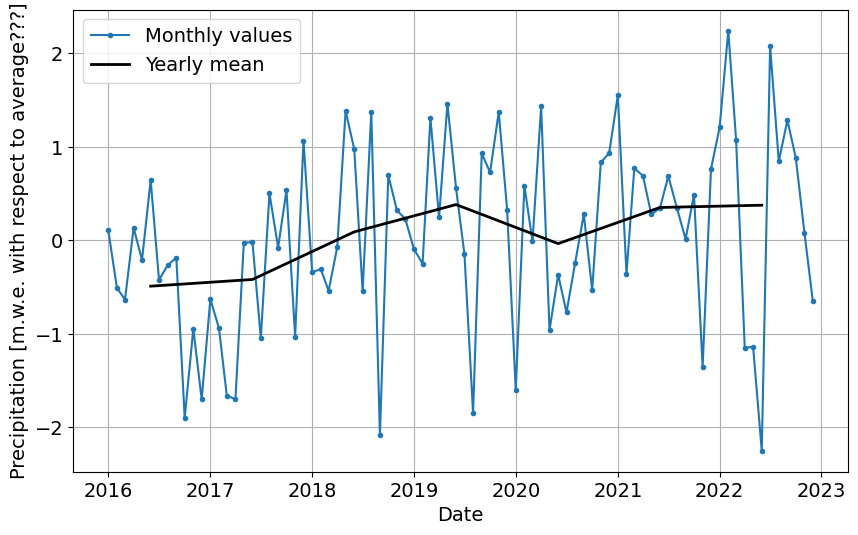

In [7]:
# Load data
fn = 'Precip_time_series_AK.csv'
precip_data = pd.read_csv(os.path.join(base_path, fn))

# Restructure dataframe so dates are in one column, precipitation is in another column
precip_data['Year'] = precip_data['Year'].astype(str)
precip_data_restruct = pd.DataFrame()
columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# iterate over month columns
for i, column in enumerate(columns):
    # grab month number
    if i+1 < 10:
        month = '0' + str(i+1)
    else:
        month = str(i+1)
    # grab dates and precipitation values for month
    dates = [np.datetime64(year + '-' + month + '-01') for year in precip_data['Year'].values]
    precip = precip_data[column].values
    # compile into dataframe
    df = pd.DataFrame({'Date': dates, 'Precipitation': precip})
    # concatenate to full dataframe
    precip_data_restruct = pd.concat([precip_data_restruct, df])
# Remove no data values
precip_data_restruct = precip_data_restruct.drop(precip_data_restruct[precip_data_restruct['Precipitation'] <= -999].index)
# Sort by date and renumber indices
precip_data_restruct.sort_values(by='Date', inplace=True)
precip_data_restruct.reset_index(drop=True, inplace=True)

# plot
plt.rcParams.update({'font.size':14, 'font.sans-serif':'Arial'})
fig, ax = plt.subplots(1, 1, figsize=(10,6))
# plot individual points
ax.plot(precip_data_restruct['Date'], precip_data_restruct['Precipitation'], '.-', label='Monthly values')
# plot yearly mean
yearly_mean = precip_data_restruct.groupby(precip_data_restruct['Date'].dt.year)['Precipitation'].mean()
dates = [np.datetime64(str(year) + '-06-01') for year in yearly_mean.index]
ax.plot(dates, yearly_mean.values, '-k', linewidth=2, label='Yearly mean')
ax.grid()
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation [m.w.e. with respect to average???]')
# ax.legend(loc='center right', bbox_to_anchor=[1.1, 0.4, 0.2, 0.2]) # plot legend outside of figure
ax.legend(loc='upper left') # plot legend in upper left corner
plt.show()

# save figure
#fig_fn = os.path.join(figures_out_path, 'precipitation_Alaska.png')
#fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
#print('figure saved to file: ' + fig_fn)

## Plot geographic distribution of sites

Total number of sites =  95


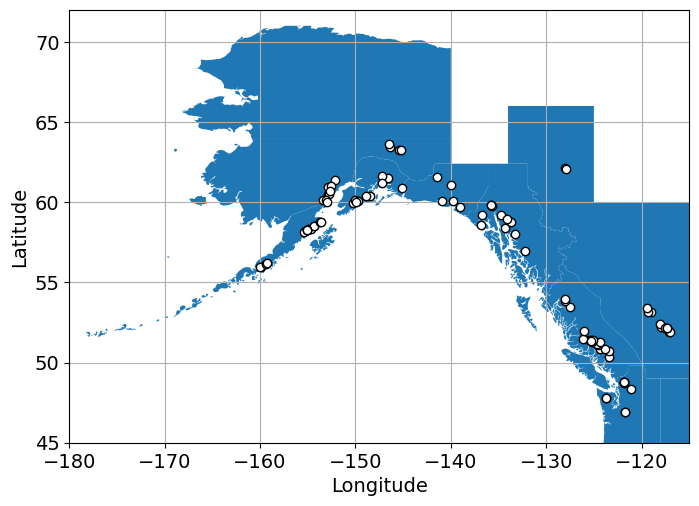

In [6]:
study_sites_path = os.path.join(base_path, 'study-sites')

# load RGI O2 regions
rgi_o2_fn = os.path.join(base_path, 'GIS_data', 'RGI2000-v7.0-regions',
                         'RGI2000-v7.0-o2regions-Alaska-westernCanadaUS_clipped_to_country_outlines.shp')
rgi_o2 = gpd.read_file(rgi_o2_fn)

# grab all site names with ELA files
site_names = sorted(os.listdir(study_sites_path))
site_names = [x for x in site_names if os.path.exists(os.path.join(study_sites_path, x, 'ELAs'))]
site_names = [x for x in site_names if len(os.listdir(os.path.join(study_sites_path, x, 'ELAs')))>0]
print('Total number of sites = ', len(site_names))

# set up figure
fig, ax = plt.subplots(1, 1, figsize=(8,8))
# plot RGI O2 regions
rgi_o2.plot(ax=ax)
# iterate over site names
for site_name in site_names:
    # load RGI outline
    aoi_fn = glob.glob(os.path.join(study_sites_path, site_name, 'AOIs', '*RGI*.shp'))[0]
    aoi = gpd.read_file(aoi_fn)
    # reproject to WGS84 if necessary
    aoi = aoi.to_crs('EPSG:4326')
    # plot centroid coordinate
    ax.plot(*aoi.geometry[0].centroid.coords.xy, 'o', markeredgecolor='k', markerfacecolor='w')

ax.grid()
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(-180, -115)
ax.set_ylim(45, 72)
plt.show()